# Load trip data and shapefiles

In [1]:
%run spatial_analysis_load.ipynb

working dir: /opt/dssg-hot/notebooks/shirley
Test commercial vs. private classification; following # should be zero: 0
Test commerical vs. private classification by num of trips; following # should be zero: 0
Test one-time use frequency classification; following # should be zero: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Group trips

#### Create groupby objects

In [2]:
fips_grouped = dfnow.groupby('fips')

In [3]:
fips_sov_grouped = dfnow[dfnow['is_hov']==0].groupby('fips')
fips_hov_grouped = dfnow[dfnow['is_hov']==1].groupby('fips')

#### Compute groups (toll intervals, time of use, user frequency, length of HOT trip)
--> see sql code by Kiana

<i>For grouping trips by toll --> toll_group</i>
<br><i>For grouping trips by entry hour --> entry_hour, peak group --> peak_group</i>
<br><i>For grouping trips by user frequency --> frequency, freq_group</i>
<br><i>For grouping trips by HOT lane trip length --> dist_group</i>
<br><i>For grouping trips by income --> inc3_group</i>

# Make sure all data and classifications/groupings are good

#### Check how many id's have an associated fips

In [4]:
fips_id_lookup = dfnow.drop_duplicates('id', keep='first')[['id','fips']]
#fips_id_lookup = pd.read_sql_query("select fips, id from census;", db)
#print(len(fips_id_lookup))
#fips_id_lookup.head()

In [5]:
num_trips_by_id = dfnow.agg({'id':'value_counts'}) # counts how many times each value appears in the column = # of trips per id
num_trips_by_id.rename(columns={'id': 'num_trips_by_id'}, inplace=True)
num_trips_by_id['id'] = num_trips_by_id.index

In [6]:
num_trips_by_id_fips = pd.merge(num_trips_by_id, fips_id_lookup, how='left', on='id')

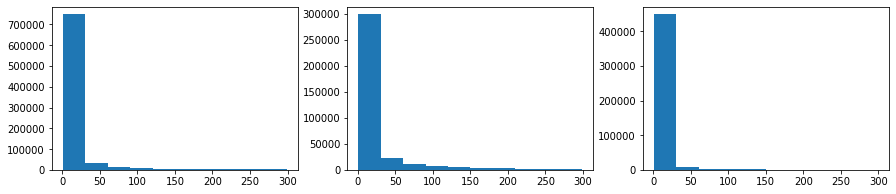

In [7]:
all_trips = num_trips_by_id_fips[(num_trips_by_id_fips['num_trips_by_id']>0) 
                             & (num_trips_by_id_fips['num_trips_by_id']<300)]['num_trips_by_id']
all_trips_wofips = num_trips_by_id_fips[(~num_trips_by_id_fips['fips'].isna()) 
              & (num_trips_by_id_fips['num_trips_by_id']>0) 
              & (num_trips_by_id_fips['num_trips_by_id']<300)]['num_trips_by_id']
all_trips_wfips = num_trips_by_id_fips[(num_trips_by_id_fips['fips'].isna()) 
              & (num_trips_by_id_fips['num_trips_by_id']>0)
              & (num_trips_by_id_fips['num_trips_by_id']<300)]['num_trips_by_id']

fig,axs=plt.subplots(1,3, figsize=(15,3))
axs[0].hist(all_trips); axs[1].hist(all_trips_wofips); axs[2].hist(all_trips_wfips);

In [8]:
print('# of trips w/o fips: ' + str(dfnow['fips'].isna().sum()))
print('total # of trips: ' + str(len(dfnow)))
print('frac of trips w/o fips: ' + str(dfnow['fips'].isna().sum()/len(dfnow)))

# of trips w/o fips: 5836315
total # of trips: 15365032
frac of trips w/o fips: 0.37984398600666763


In [9]:
print('# of ids w/o fips: ' + str(num_trips_by_id_fips['fips'].isna().sum()))
print('total # of ids: ' + str(len(num_trips_by_id_fips)))
print('frac of ids w/o fips: ' + str(num_trips_by_id_fips['fips'].isna().sum()/len(num_trips_by_id_fips)))

# of ids w/o fips: 463888
total # of ids: 826679
frac of ids w/o fips: 0.5611464667664232


#### Check if there are block groups in the trips file, but not in the census block group shapefile

In [10]:
# - Get all Washington state block groups in the all trips file
# --> all WA state block groups start w/ 53, w/ a total of 12 digits
print('Total # of unique WA fips in all trips: ' + 
      str(len(
          dfnow[(dfnow['fips']>=530000000000)
                & (dfnow['fips']<540000000000)]['fips'].unique())))

Total # of unique WA fips in all trips: 3306


In [11]:
print('Total # of unique fips in cbgs WA shapefile: ' + 
      str(len(cbgs['fips'].unique())))

Total # of unique fips in cbgs WA shapefile: 4783


In [12]:
print('Total # of unique fips in acs WA file: ' + 
      str(len(acs['fips'].unique())))

Total # of unique fips in acs WA file: 4783


#### Check how many block groups don't have certain variables (avg toll, median income, ...)

In [13]:
cbgs_joinnow = cbgs_acs.merge(fips_sov_grouped.agg({'toll': 'mean'}), on='fips', how='left') # avg toll over sov per bg
print('# of bgs: ' + str(len(cbgs_joinnow)))
print('# of null avg toll: ' + str(len(cbgs_joinnow[cbgs_joinnow['toll'].isnull()])))
print('# of null med inc: ' + str(len(cbgs_joinnow[cbgs_joinnow['med_inc'].isnull()])))
print('# of null avg toll or med inc: ' + str(len(cbgs_joinnow[cbgs_joinnow['med_inc'].isnull() | cbgs_joinnow['toll'].isnull()])))

# of bgs: 4783
# of null avg toll: 2202
# of null med inc: 109
# of null avg toll or med inc: 2235


In [18]:
fips_med_inc_lookup = dfnow[['trip_id','fips']].merge(cbgs_joinnow[['med_inc','fips']], on='fips', how='left')

AttributeError: 'Series' object has no attribute 'merge'

In [ ]:
fips_med_inc_lookup = dfnow.drop_duplicates('fips', keep='first')[['med_inc']].squeeze()

In [ ]:
# - Compare median income distribs from all acs, cbgs join (each fips wt = 1), all trips bgs (each fips wt = 1) 
print('all acs bgs med med inc: ' + str(cbgs_acs['med_inc'].median()))
print('cbgs join bgs med med inc: ' + str(cbgs_joinnow['med_inc'].median()))
print('all trips bgs med med inc: ' + str(fips_med_inc_lookup.median()))

fig,axs=plt.subplots(1,3, figsize=(15,3))
axs[0].hist(cbgs_acs['med_inc'], bins=30);
axs[1].hist(cbgs_joinnow['med_inc'], bins=30);
axs[2].hist(fips_med_inc_lookup, bins=30);

#### Make sure median income separation bins are good

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [ ]:
print('all acs bgs inc bin edges: ' + str(histedges_equalN(cbgs_acs['med_inc'],3)))
print('cbgs join bgs inc bin edges: ' + str(histedges_equalN(cbgs_joinnow['med_inc'],3)))
print('all trips bgs inc bin edges: ' + str(histedges_equalN(fips_med_inc_lookup,3)))

# Cleanup

In [15]:
del(fips_med_inc_lookup, all_trips, all_trips_wofips, all_trips_wfips, fips_id_lookup)
gc.collect()

NameError: name 'fips_med_inc_lookup' is not defined

# Create lookup tables for groupings

In [ ]:
def toll_group_defn(row):
    if row['toll_group']==0:
        val = "0-1"
    elif row['toll_group']==1:
        val = ">1-2"
    elif row['toll_group']==2:
        val = ">2-4"      
    elif row['toll_group']==3:
        val = ">4-6"
    elif row['toll_group']==4:
        val = ">6-8"
    elif row['toll_group']==5:
        val = ">8-10"
    elif row['toll_group']==6:
        val = ">10?"
    return val

toll_group_defn_lu_table = pd.DataFrame({'toll_group':[0,1,2,3,4,5,6]}) 
toll_group_defn_lu_table['toll_group_str'] = toll_group_defn_lu_table.apply(toll_group_defn, axis=1)

In [ ]:
def peak_group_defn(row):
    if row['peak_group']==0:
        val = "NB_m_pk"
    elif row['peak_group']==1:
        val = "SB_m_pk"
    elif row['peak_group']==2:
        val = "NB_e_pk"      
    elif row['peak_group']==3:
        val = "SB_e_pk"
    elif row['peak_group']==4:
        val = "offpk"
    return val

peak_group_defn_lu_table = pd.DataFrame({'peak_group':[0,1,2,3,4]}) 
peak_group_defn_lu_table['peak_group_str'] = peak_group_defn_lu_table.apply(peak_group_defn, axis=1)

In [ ]:
def freq_group_defn(row):
    if row['freq_group']==0:
        val = "1"
    elif row['freq_group']==1:
        val = "2-20"
    elif row['freq_group']==2:
        val = "21-70"      
    elif row['freq_group']==3:
        val = "71-200"
    elif row['freq_group']==4:
        val = "201-400"
    elif row['freq_group']==5:
        val = ">401"
    elif row['freq_group']==6:
        val = "0?"
    return val

freq_group_defn_lu_table = pd.DataFrame({'freq_group':[0,1,2,3,4,5,6]}) 
freq_group_defn_lu_table['freq_group_str'] = freq_group_defn_lu_table.apply(freq_group_defn, axis=1)

In [ ]:
def dist_group_defn(row):
    if row['dist_group']==0:
        val = "0-4"
    elif row['dist_group']==1:
        val = ">4-6"
    elif row['dist_group']==2:
        val = ">6-8"      
    elif row['dist_group']==3:
        val = ">8-10"  
    elif row['dist_group']==4:
        val = ">10-12"  
    elif row['dist_group']==5:
        val = ">12"  
    elif row['dist_group']==6:
        val = "?"
    return val

dist_group_defn_lu_table = pd.DataFrame({'dist_group':[0,1,2,3,4,5,6]}) 
dist_group_defn_lu_table['dist_group_str'] = dist_group_defn_lu_table.apply(dist_group_defn, axis=1)

In [ ]:
def inc_group_defn(row):
    if row['inc_group']==0:
        val = "low"
    elif row['inc_group']==1:
        val = "med"
    elif row['inc_group']==2:
        val = "high"
    elif row['inc_group']==3:
        val = "?"
    return val

inc_group_defn_lu_table = pd.DataFrame({'inc_group':[0,1,2,3]}) 
inc_group_defn_lu_table['inc_group_str'] = inc_group_defn_lu_table.apply(inc_group_defn, axis=1)

# Create csv file for vars aggregated over block groups
--> to use in Tableau and elsewhere

In [ ]:
# - Load census block groups
cbgs = gpd.read_file('/opt/dssg-hot/data/shapefiles/block_groups_WA/bg10.shp')
#cbgs.dtypes
#cbgs.head()
#cbgs.crs
cbgs = cbgs[['GEOID10','geometry']]
cbgs.rename(columns={'GEOID10':'fips'}, inplace=True)
cbgs['fips'] = pd.to_numeric(cbgs['fips'])
cbgs['geometry'] = cbgs['geometry'].to_crs(epsg=4326)

# - Load ACS 2016 info
acs = pd.read_csv('/opt/dssg-hot/data/acs/block_group_census_estimates_wide_original_bins_all_WA.csv')
acs.rename(columns={'fips_code':'fips'}, inplace=True)
#acs.dtypes

cbgs_acs = cbgs.merge(acs, on='fips')

#### Add in acs data

In [ ]:
cbgs_dfnow = cbgs_acs[['fips','geometry','county_name','mean_inc','med_age','med_inc','pc_income',
                       'households','population','race_nonhisp_asian','race_nonhisp_white','trans_carpool',
                       'trans_drivealone','trans_transit']]

#### Define majority forward and reverse commute block groups

In [ ]:
fips_peak_grouped = dfnow.groupby(['fips','peak_group'])
#peak_grouped = dfnow.groupby(['peak_group'])
#fips_peak_grouped.count()

In [ ]:
# - Define reverse dir trips
colnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).xs(0, level='peak_group') # 'NB_m_pk'
colnow.rename(columns={'trip_id': 'num_NB_m_pk_trips'},inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(colnow, how='left', on='fips')
colnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).xs(3, level='peak_group') # 'SB_e_pk'
colnow.rename(columns={'trip_id': 'num_SB_e_pk_trips'},inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(colnow, how='left', on='fips')

In [ ]:
# - Define forward dir trips
colnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).xs(2, level='peak_group') # 'NB_e_pk'
colnow.rename(columns={'trip_id': 'num_NB_e_pk_trips'},inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(colnow, how='left', on='fips')
colnow = fips_peak_grouped.agg({'trip_id': 'nunique'}).xs(1, level='peak_group') # 'SB_m_pk'
colnow.rename(columns={'trip_id': 'num_SB_m_pk_trips'},inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(colnow, how='left', on='fips')

In [ ]:
# - Calc tot trips
cbgs_dfnow = cbgs_dfnow.merge(
    fips_grouped['trip_id'].nunique(), how='left', on='fips')
cbgs_dfnow.rename(
    columns={'trip_id':'num_trips'}, inplace=True)

In [ ]:
# - Calc tot trips/household, tot trips/capita, and frac forward/reverse dir trips for each bg
cbgs_dfnow['num_trips_pc'] = cbgs_dfnow['num_trips']/cbgs_dfnow['population']
cbgs_dfnow['num_trips_ph'] = cbgs_dfnow['num_trips']/cbgs_dfnow['households']
# fd = forward commute direction
cbgs_dfnow['frac_fd_trips'] = (cbgs_dfnow['num_NB_e_pk_trips']+cbgs_dfnow['num_SB_m_pk_trips']
                          )/cbgs_dfnow['num_trips']
# rd = reverse commute direction
cbgs_dfnow['frac_rd_trips'] = (cbgs_dfnow['num_NB_m_pk_trips']+cbgs_dfnow['num_SB_e_pk_trips']
                          )/cbgs_dfnow['num_trips']

In [ ]:
# - Look at the distrib of frac forward/reverse dir trips among all bgs
fig,axes=plt.subplots(1,2,figsize=(7,3))
axes[0].hist(cbgs_dfnow['frac_fd_trips']); axes[0].set_title('frac_fd_trips');
axes[1].hist(cbgs_dfnow['frac_rd_trips']); axes[1].set_title('frac_rd_trips');

In [ ]:
# - Look at the distrib of tot trips among all bgs
fig,axes=plt.subplots(1,2,figsize=(7,3))
axes[0].hist(cbgs_dfnow[cbgs_dfnow['num_trips']>100]['num_trips'], bins=30); axes[0].set_title('num_trips, >100');
axes[1].hist(cbgs_dfnow[cbgs_dfnow['num_trips']>1000]['num_trips'], bins=30); axes[1].set_title('num_trips, >1000');

In [ ]:
# - Calc centroids
#cbgs_dfnow.dropna(subset = ['geometry'], inplace=True)
#cbgs_dfnow['geometry'].geom_type.unique()
cbgs_dfnow['lon'] = cbgs_dfnow.centroid.x
cbgs_dfnow['lat'] = cbgs_dfnow.centroid.y

In [ ]:
# - Plot maps of frac forward/reverse dir trips by bgs + above/below E-W line --> defining reverse/forward commute block groups
fig,axes = plt.subplots(2, 2, figsize = (16,20))

vmin=0; vmax=1

axes[0][0].set_ylim([47.25, 48.22]); axes[0][0].set_xlim([-122.45, -121.85]); axes[0][0].set_title('Frac forward commute direction trips')
cbgs_dfnow.plot(column = 'frac_fd_trips', ax = axes[0][0], legend = True, vmin = vmin, vmax = vmax)
majlks.plot(ax=axes[0][0], color='paleturquoise', linewidth=3); majrds.plot(ax=axes[0][0], color='gray', linewidth=3)
majtpsnb.plot(ax=axes[0][0], color='magenta', markersize=100); majcps.plot(ax=axes[0][0], color='white')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    axes[0][0].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')

axes[0][1].set_ylim([47.25, 48.22]); axes[0][1].set_xlim([-122.45, -121.85]); axes[0][1].set_title('Frac reverse commute direction trips')
cbgs_dfnow.plot(column = 'frac_rd_trips', ax = axes[0][1], legend = True, vmin = vmin, vmax = vmax)
majlks.plot(ax=axes[0][1], color='paleturquoise', linewidth=3); majrds.plot(ax=axes[0][1], color='gray', linewidth=3)
majtpsnb.plot(ax=axes[0][1], color='magenta', markersize=100); majcps.plot(ax=axes[0][1], color='white')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    axes[0][1].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')

vmin=0; vmax=0.5

axes[1][0].set_ylim([47.25, 48.22]); axes[1][0].set_xlim([-122.45, -121.85]); axes[1][0].set_title('Frac forward commute direction trips')
cbgs_dfnow[cbgs_dfnow['lat']>47.6].plot(column = 'frac_fd_trips', ax = axes[1][0], legend = True, vmin = vmin, vmax = vmax)
majlks.plot(ax=axes[1][0], color='paleturquoise', linewidth=3); majrds.plot(ax=axes[1][0], color='gray', linewidth=3)
majtpsnb.plot(ax=axes[1][0], color='magenta', markersize=100); majcps.plot(ax=axes[1][0], color='white')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    axes[1][0].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')

axes[1][1].set_ylim([47.25, 48.22]); axes[1][1].set_xlim([-122.45, -121.85]); axes[1][1].set_title('Frac reverse commute direction trips')
cbgs_dfnow[cbgs_dfnow['lat']<47.7].plot(column = 'frac_rd_trips', ax = axes[1][1], legend = True, vmin = vmin, vmax = vmax)
majlks.plot(ax=axes[1][1], color='paleturquoise', linewidth=3); majrds.plot(ax=axes[1][1], color='gray', linewidth=3)
majtpsnb.plot(ax=axes[1][1], color='magenta', markersize=100); majcps.plot(ax=axes[1][1], color='white')
for x, y, label in zip(majcps.geometry.x, majcps.geometry.y, majcps.NAME):
    axes[1][1].annotate(label, xy=(x, y), xytext=(3, 3), textcoords='offset points', color='white')
    
fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/fips_frac_forward_reverse_commute_direction_trips.pdf', bbox_inches='tight', pad_inches = 0)

In [ ]:
# - Define majority forward/reverse dir bgs
# --> majority forward dir (fd) bg must:
# 1.) have >50% of trips be during SB evening peak or NB morning peak,
# 2.) have its centroid above 47.6 deg N
# --> majority reverse dir (rd) bg must:
# 1.) have >50% of trips be during SB morning peak or NB evening peak,
# 2.) have its centroid below 47.7 deg N
def maj_commute_dir_fxn(row):
    if (row['frac_fd_trips']>0.5) & (row['lat']>47.6):
        val = 'fd'
    elif (row['frac_rd_trips']>0.5) & (row['lat']<47.7):
        val = 'rd'
    else:
        val = 'nd'
    return val

cbgs_dfnow['maj_commute_dir'] = cbgs_dfnow.apply(maj_commute_dir_fxn, axis=1)

#### Add in many other block group level aggregated variables

In [ ]:
# - Avg dist traveled in HOT lanes
cbgs_dfnow = cbgs_dfnow.merge(fips_grouped.agg(
    {'dist_btwn_entry_exit_loop': 'mean'}), on='fips', how='left')
cbgs_dfnow.rename(
    columns={'dist_btwn_entry_exit_loop':'avg_dist'},inplace=True)

In [ ]:
# - Avg toll paid w/o HOV
cbgs_dfnow = cbgs_dfnow.merge(fips_sov_grouped.agg(
    {'toll': 'mean'}), on='fips', how='left')
cbgs_dfnow.rename(
    columns={'toll':'avg_toll_wohov'},inplace=True)

In [ ]:
# - Avg toll paid w/ HOV
cbgs_dfnow = cbgs_dfnow.merge(fips_grouped.agg(
    {'toll': 'mean'}), on='fips', how='left')
cbgs_dfnow.rename(
    columns={'toll':'avg_toll_whov'},inplace=True)

In [ ]:
# - Number of unique ids
cbgs_dfnow = cbgs_dfnow.merge(
    fips_grouped['id'].nunique(), on='fips', how='left')
cbgs_dfnow.rename(
    columns={'id':'num_ids'}, inplace=True)
cbgs_dfnow['ids_pc'] = cbgs_dfnow['num_ids']/cbgs_dfnow['population']
cbgs_dfnow['ids_ph'] = cbgs_dfnow['num_ids']/cbgs_dfnow['households']

In [ ]:
# - Number of trips per id
cbgs_dfnow = cbgs_dfnow.merge(
    num_trips_by_id_fips.groupby('fips').agg(
        {'num_trips_by_id':'mean'}), on='fips', how='left')
cbgs_dfnow.rename(
    columns={'num_trips_by_id':'avg_num_trips_by_id'}, inplace=True)
cbgs_dfnow['avg_num_trips_by_id_ph'] = cbgs_dfnow['avg_num_trips_by_id']/cbgs_dfnow['households']
cbgs_dfnow['avg_num_trips_by_id_pc'] = cbgs_dfnow['avg_num_trips_by_id']/cbgs_dfnow['population']

In [ ]:
# - % HOV/SOV
fips_shov_grouped = dfnow.groupby(['fips','is_hov'])
perc_trips_within_bgnow = fips_shov_grouped.agg({'trip_id': 'nunique'}).div(
    fips_grouped.agg({'trip_id': 'nunique'}, level='fips'))*100
perc_trips_within_bgnow = perc_trips_within_bgnow.unstack(level='is_hov')
perc_trips_within_bgnow.columns = perc_trips_within_bgnow.columns.droplevel(0)
perc_trips_within_bgnow.reset_index(inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(perc_trips_within_bgnow, on='fips', how='left')
cbgs_dfnow.rename(columns={0:'perc_sov_trips',1:'perc_hov_trips'}, inplace=True)

In [ ]:
# - Travel time savings
cbgs_dfnow = cbgs_dfnow.merge(
    fips_grouped.agg(
        {'tt_savings':'mean'}), on='fips', how='left')
cbgs_dfnow.rename(columns={'tt_savings':'avg_tt_savings'}, inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(
    fips_grouped.agg(
        {'tt_savings':'sum'}), on='fips', how='left')
cbgs_dfnow.rename(columns={'tt_savings':'tot_tt_savings'}, inplace=True)

In [ ]:
# - Reliability savings
cbgs_dfnow = cbgs_dfnow.merge(
    fips_grouped.agg(
        {'reliab_savings':'mean'}), on='fips', how='left')
cbgs_dfnow.rename(columns={'reliab_savings':'avg_reliab_savings'}, inplace=True)
cbgs_dfnow = cbgs_dfnow.merge(
    fips_grouped.agg(
        {'reliab_savings':'sum'}), on='fips', how='left')
cbgs_dfnow.rename(columns={'reliab_savings':'tot_reliab_savings'}, inplace=True)

#### Save out the final csv

In [ ]:
cbgs_dfnow.to_csv(r'/opt/dssg-hot/data/block_group_aggregates/cbgs_fips_vars_with_geometry.csv')

In [ ]:
cbgs_dfnow_pd = pd.DataFrame(cbgs_dfnow.drop(columns='geometry'))
cbgs_dfnow_pd.to_csv(r'/opt/dssg-hot/data/block_group_aggregates/cbgs_fips_vars.csv')